## Assignment: PCA vs. t-SNE on Epileptic Seizure Recognition Dataset

You will be provided a link to the dataset, which is identical to the original UCI Epileptic Seizure Recognition Dataset here:
https://archive.ics.uci.edu/ml/datasets/Epileptic+Seizure+Recognition#

Perform the following steps without and then with standard scaling of the dataset:

1) Perform PCA analysis on the epileptic seizure dataset using 2 components.

2) Plot the first 2 principal components.

3) Apply t-SNE to the epileptic seizure dataset.

4) You will have to experiment with perplexity (5, 50) and number of iterations (>1000).

5) Plot your t-SNE projections adjacent to your PCA plot and record your observations.

6) Repeat steps 4 and 5 until you are satisfied with t-SNE being able to separate classes in the data set.

7) Record your optimal perplexity and iterations for t-SNE. Compare the PCA and t-SNE visualizations and record your results.

### UCI Epileptic Seizure Recognition Dataset

The patient id is in column 1 which is unnamed, the response variable y (also called the diagnosis field) is in column 180, and the explanatory variables are X1, X2, ..., X178.

The diagnosis field (y) contains the category of the 178-dimensional input vector. Specifically, y in {1, 2, 3, 4, 5} means the following:

    1 - YES seizure - Recording of seizure activity

    2 - NO seizure - But they recorded the EEG from the area where the tumor was located

    3 - NO seizure - But they identify where the region of the tumor was in the brain and recording the EEG activity from the healthy brain area

    4 - NO seizure - But eyes closed, means when they were recording the EEG signal the patient had their eyes closed

    5 - NO seizure - But eyes open, means when they were recording the EEG signal of the brain the patient had their eyes open

All subjects falling in classes 2, 3, 4, and 5 are subjects who did NOT have epileptic seizure. Only subjects in class 1 presented with epileptic seizure. The authors' motivation for creating this version of the data was to simplify access to the data via the creation of a .csv version of it. Although there are 5 classes, most authors have done binary classification, namely class 1 (epileptic seizure) against the rest which are set to 0. This is what we'll be doing.



In [27]:
# Load important libraries
import pandas as pd
import numpy as np
from IPython.display import HTML
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Load the dataset
data_url = "https://raw.githubusercontent.com/Thinkful-Ed/data-science-lectures/master/data-epilepsy-original.csv"
df = pd.read_csv(data_url,)

In [3]:
# Examine the dataset
df.head()

,Unnamed: 0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,X21.V1.791,135,190,229,223,192,125,55,-9,-33,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
1,X15.V1.924,386,382,356,331,320,315,307,272,244,...,164,150,146,152,157,156,154,143,129,1
2,X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,...,57,64,48,19,-12,-30,-35,-35,-36,5
3,X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,5
4,X20.V1.54,-9,-65,-98,-102,-78,-48,-16,0,-21,...,4,2,-12,-32,-41,-65,-83,-89,-73,5


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11500 entries, 0 to 11499
Columns: 180 entries, Unnamed: 0 to y
dtypes: int64(179), object(1)
memory usage: 15.8+ MB


The first column, which is unnamed but is used for patient id, should be removed, since it is unnecessary. The dataset will also be examined for missing values, duplicated entries and unique values of 'diagnosis' column.

In [10]:
# Remove unnecessary columns
df = df.drop(columns=['Unnamed: 0'])

In [11]:
df.duplicated().sum()

0

In [12]:
# Find missing values
df.isna().sum()
# Find duplicated records
df.duplicated().sum()
# Find the unique values of 'diagnosis'
df['y'].value_counts()

5    2300
4    2300
3    2300
2    2300
1    2300
Name: y, dtype: int64

In [16]:
# To focus on a seizure vs. no seizure binary outcome, all diagnosis ratings = 2,3,4,5 will be set to no seizure (0)
# Whereas diagnosis = 1 is yes seizure so it will remain as is
df['y'] = df['y'].replace({1: 1, 2: 0, 3: 0, 4: 0, 5: 0})

# Now find the unique values of 'diagnosis' after binarization
df['y'].value_counts()

0    9200
1    2300
Name: y, dtype: int64

### Do some data exploration

In [18]:
# Check the dimensions again
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11500 entries, 0 to 11499
Columns: 179 entries, X1 to y
dtypes: int64(179)
memory usage: 15.7 MB


In [19]:
# Generate statistics
df.describe()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
count,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.00000,11500.00000,11500.000000,...,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000
mean,-11.581391,-10.911565,-10.187130,-9.143043,-8.009739,-7.003478,-6.502087,-6.68713,-6.55800,-6.168435,...,-10.145739,-11.630348,-12.943478,-13.668870,-13.363304,-13.045043,-12.705130,-12.426000,-12.195652,0.200000
std,165.626284,166.059609,163.524317,161.269041,160.998007,161.328725,161.467837,162.11912,162.03336,160.436352,...,164.652883,166.149790,168.554058,168.556486,167.257290,164.241019,162.895832,162.886311,164.852015,0.400017
min,-1839.000000,-1838.000000,-1835.000000,-1845.000000,-1791.000000,-1757.000000,-1832.000000,-1778.00000,-1840.00000,-1867.000000,...,-1867.000000,-1865.000000,-1642.000000,-1723.000000,-1866.000000,-1863.000000,-1781.000000,-1727.000000,-1829.000000,0.000000
25%,-54.000000,-55.000000,-54.000000,-54.000000,-54.000000,-54.000000,-54.000000,-55.00000,-55.00000,-54.000000,...,-55.000000,-56.000000,-56.000000,-56.000000,-55.000000,-56.000000,-55.000000,-55.000000,-55.000000,0.000000
50%,-8.000000,-8.000000,-7.000000,-8.000000,-8.000000,-8.000000,-8.000000,-8.00000,-7.00000,-7.000000,...,-9.000000,-10.000000,-10.000000,-10.000000,-10.000000,-9.000000,-9.000000,-9.000000,-9.000000,0.000000
75%,34.000000,35.000000,36.000000,36.000000,35.000000,36.000000,35.000000,36.00000,36.00000,35.250000,...,34.000000,34.000000,33.000000,33.000000,34.000000,34.000000,34.000000,34.000000,34.000000,0.000000
max,1726.000000,1713.000000,1697.000000,1612.000000,1518.000000,1816.000000,2047.000000,2047.00000,2047.00000,2047.000000,...,1777.000000,1472.000000,1319.000000,1436.000000,1733.000000,1958.000000,2047.000000,2047.000000,1915.000000,1.000000


Plot pairwise relationships to check the correlations between the mean features.

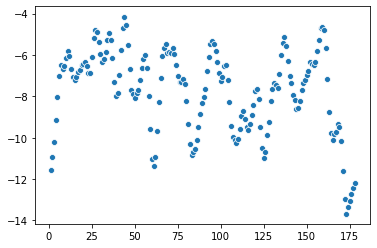

In [28]:
means = df.drop(columns='y').mean()
sns.scatterplot(x=np.arange(1,179), y=means)

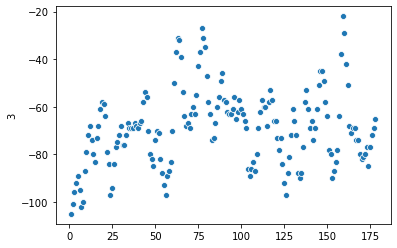

In [33]:
sns.scatterplot(x=np.arange(1,179), y=df.iloc[3,:-1])

Store the diagnosis column (y) in a target object and then drop it from X

In [34]:
X = df.drop(columns=['y'])
y = df['y']

In [35]:
X

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X169,X170,X171,X172,X173,X174,X175,X176,X177,X178
0,135,190,229,223,192,125,55,-9,-33,-38,...,8,-17,-15,-31,-77,-103,-127,-116,-83,-51
1,386,382,356,331,320,315,307,272,244,232,...,168,164,150,146,152,157,156,154,143,129
2,-32,-39,-47,-37,-32,-36,-57,-73,-85,-94,...,29,57,64,48,19,-12,-30,-35,-35,-36
3,-105,-101,-96,-92,-89,-95,-102,-100,-87,-79,...,-80,-82,-81,-80,-77,-85,-77,-72,-69,-65
4,-9,-65,-98,-102,-78,-48,-16,0,-21,-59,...,10,4,2,-12,-32,-41,-65,-83,-89,-73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11495,-22,-22,-23,-26,-36,-42,-45,-42,-45,-49,...,20,15,16,12,5,-1,-18,-37,-47,-48
11496,-47,-11,28,77,141,211,246,240,193,136,...,-94,-65,-33,-7,14,27,48,77,117,170
11497,14,6,-13,-16,10,26,27,-9,4,14,...,-42,-65,-48,-61,-62,-67,-30,-2,-1,-8
11498,-40,-25,-9,-12,-2,12,7,19,22,29,...,114,121,135,148,143,116,86,68,59,55


pandas.core.series.Series

### Visualizing PCA and t-SNE Plots

- Instantiate a PCA instance with `n_components`=2

- Fit and transform your PCA model on data `X`

- Instantiate a TNSE instance with `n_components`=2, `verbose`=1, and experiment with the `perplexity` and `n_iter` parameters. `perplexity` should be between 5 and 50. `n_iterations` > 1000.

- Fit and transform your TSNE model on data `X`

In [43]:
# Turn dataframe into arrays
X = np.array(X)

# Invoke the PCA method. Since this is a binary classification problem
# let's call n_components = 2
pca = PCA(2)
X_pca = pca.fit_transform(X)
# Invoke the TSNE method
# Instantiate a TSNE instance
# tsne = TSNE(n_components=2, verbose=1)

In [41]:
tsne = TSNE(n_components=2, verbose=1)
X_tsne = tsne.fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 11500 samples in 0.552s...
[t-SNE] Computed neighbors for 11500 samples in 62.692s...
[t-SNE] Computed conditional probabilities for sample 1000 / 11500
[t-SNE] Computed conditional probabilities for sample 2000 / 11500
[t-SNE] Computed conditional probabilities for sample 3000 / 11500
[t-SNE] Computed conditional probabilities for sample 4000 / 11500
[t-SNE] Computed conditional probabilities for sample 5000 / 11500
[t-SNE] Computed conditional probabilities for sample 6000 / 11500
[t-SNE] Computed conditional probabilities for sample 7000 / 11500
[t-SNE] Computed conditional probabilities for sample 8000 / 11500
[t-SNE] Computed conditional probabilities for sample 9000 / 11500
[t-SNE] Computed conditional probabilities for sample 10000 / 11500
[t-SNE] Computed conditional probabilities for sample 11000 / 11500
[t-SNE] Computed conditional probabilities for sample 11500 / 11500
[t-SNE] Mean sigma: 156.948003
[t-SNE] KL diverge

In [51]:
X_tsne[:,1]

array([ 19.760141,  47.766018,  33.207615, ..., -12.891773,  25.365042,
       -14.211191], dtype=float32)

In [48]:
y

0        0
1        1
2        0
3        0
4        0
        ..
11495    0
11496    1
11497    0
11498    0
11499    0
Name: y, Length: 11500, dtype: int64

Plot the results.

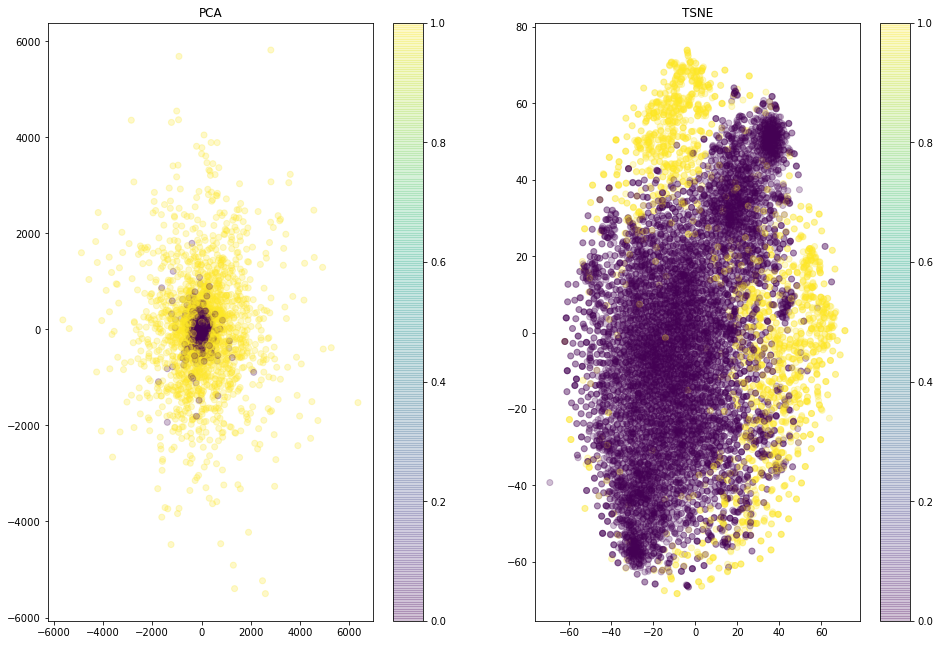

In [59]:
# Plot the TSNE and PCA visuals side-by-side
plt.figure(figsize=(16, 11))
plt.subplot(121)
plt.scatter(
X_pca[:,0], X_pca[:,1], c=y, alpha=0.25
)
plt.colorbar()
plt.title('PCA')
plt.subplot(122)
plt.scatter(
X_tsne[:,0], X_tsne[:,1], c=y, alpha=0.25
)
plt.colorbar()
plt.title('TSNE')
plt.show()

### Record your observations on the PCA and TSNE plots

As one can see from these high-level plots, even though PCA does quite a decent job of visualising our two target clusters, the visuals in TSNE is much more obvious in terms of the demarcation in the target.

### Standardization and Visualization

Try scaling (or standardizing) our features and see if we can get even more obvious/intuitive clusters in our plots.

Use StandardScaler to standardize `X` and repeat the experiment.

In [60]:
# Call Sklearn scaling method
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

In [63]:
# Invoke the PCA method on the standardized data
pca = PCA(2)
X_std_pca = pca.fit_transform(X_std)
# Invoke the TSNE method
tsne = TSNE(n_components=2, verbose=1)
X_std_tsne = tsne.fit_transform(X_std)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 11500 samples in 0.467s...
[t-SNE] Computed neighbors for 11500 samples in 54.088s...
[t-SNE] Computed conditional probabilities for sample 1000 / 11500
[t-SNE] Computed conditional probabilities for sample 2000 / 11500
[t-SNE] Computed conditional probabilities for sample 3000 / 11500
[t-SNE] Computed conditional probabilities for sample 4000 / 11500
[t-SNE] Computed conditional probabilities for sample 5000 / 11500
[t-SNE] Computed conditional probabilities for sample 6000 / 11500
[t-SNE] Computed conditional probabilities for sample 7000 / 11500
[t-SNE] Computed conditional probabilities for sample 8000 / 11500
[t-SNE] Computed conditional probabilities for sample 9000 / 11500
[t-SNE] Computed conditional probabilities for sample 10000 / 11500
[t-SNE] Computed conditional probabilities for sample 11000 / 11500
[t-SNE] Computed conditional probabilities for sample 11500 / 11500
[t-SNE] Mean sigma: 1.074765
[t-SNE] KL divergenc

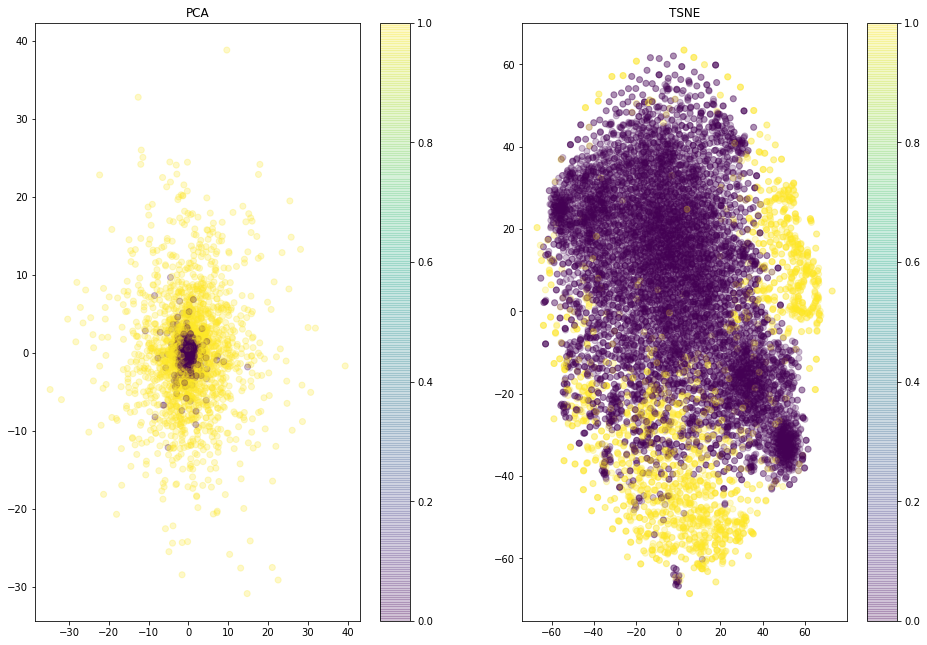

In [64]:
# Plot the TSNE and PCA visuals side-by-side
plt.figure(figsize=(16, 11))
plt.subplot(121)
plt.scatter(
X_std_pca[:,0], X_std_pca[:,1], c=y, alpha=0.25
)
plt.colorbar()
plt.title('PCA')
plt.subplot(122)
plt.scatter(
X_std_tsne[:,0], X_std_tsne[:,1], c=y, alpha=0.25
)
plt.colorbar()
plt.title('TSNE')
plt.show()

#### Record your observations

What are your observations?
